In [ ]:
!pip install pyLDAvis
import pandas as pd
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import string
import nltk
import chardet
import warnings
from ast import literal_eval
warnings.filterwarnings("ignore")
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.util import ngrams
from collections import Counter 
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV
import pyLDAvis.sklearn
import pickle 
import pyLDAvis
from textblob import TextBlob
from nltk.corpus import wordnet
import tqdm
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from pprint import pprint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 27.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=4895807f8106fbeab72a3ea5e17f686165156c23f03ec1f1922ecb6c02e89d28
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=b6bb2defb835dc0588370c13ff05e984924392c4ab9c979813ff23cce40242e6
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
df = pd.read_csv('tweets_clean_entity.csv')

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# To remove additional stopwords that might cause irrelevant words to come up in topic modelling
my_stopwords = nltk.corpus.stopwords.words('english')

df['clean_tweet_tokens']=df['clean_tweet_tokens'].apply(lambda x: literal_eval(str(x)))

necessary_removal=['link','amp','quot','line','give','get','make','also','know','yet','never',\
                   'via','come','take','came','like','call','free','see','time','today','need',\
                  'open','think','cool','temporary','use','day','check','possibly','look',\
                  'want','way','work','live','around','great','set','tweet','thanks','beautifully',\
                  'write','thanks','many','best','awesome','include','pop',\
                  'say','photo','let','wait','long','panel','rumor','valid','talk','keep','big'\
                  ,'yes','please','well','pic','show','temp','ready','show','anyone','join'\
                  ,'still','next','could','ever','com','away','much','ask'\
                  ,'must','right','everyone','everywhere','others','tonight','feel','every','learn'\
                  ,'really','else','back','bar','already','try','person'\
                  ,'hope','might','even','turn','tomorrow','corner','skip','jump','daily','sure','someone'\
                  ,'lot','put','wow','tell','stuff','wish','share','watch','fun','find','would','hey','miss'\
                  ,'likely','regularly','fell','begin','lose','change','bad','phase','top'\
                  ,'post','stop','info','site','maybe'\
                  ,'headache','may','another','full','enter','something','thing','bring','late'\
                  ,'weekend','play','speak','charge','rock','meet','seem','mashable','pad','excite'\
                  ,'sign','walk','far','session','code','update',\
                  'life','plenty','found','able','view','folk','view','saw','thought'\
                  ,'says','using','hrs','giving','got','made','dems']
my_stopwords.extend(necessary_removal)
df['clean_tweet_tokens']=df['clean_tweet_tokens'].apply(lambda x: [word for word in x if word not in my_stopwords])
df['clean_tweet_tokens'].head(5)

0                       [hear, west, wing—thank]
1      [pennsylvania, trump, legislator, spoken]
2                     [smart, republican, fight]
3     [wonder, water, main, gon, burst, georgia]
4    [democrat, scrounge, vote, mystical, place]
Name: clean_tweet_tokens, dtype: object

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df_19_20 = df[(df['Year'] == 2019) | (df['Year'] == 2020)]

In [ ]:
df_19_20['clean_tweet_text']=df_19_20['clean_tweet_tokens'].apply(lambda x: ' '.join(x))

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern=r'\w{1,}')

# apply transformation
tf = vectorizer.fit_transform(df_19_20['clean_tweet_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

#to check the shape of tf
tf.shape

# the vectorizer object will be used to transform text to vector form
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=25, token_pattern=r'\w{1,}')

# apply transformation
tfidf = tfidf_vectorizer.fit_transform(df_19_20['clean_tweet_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#to check the shape of tf
tfidf.shape

(20016, 1333)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(df_19_20['clean_tweet_tokens'])
# Create Corpus
texts = df_19_20['clean_tweet_tokens']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[]]


In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df_19_20['clean_tweet_tokens'], dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 30
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=0.01, b=0.01)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Alpha'].append(0.01)
            model_results['Beta'].append(0.01)
            model_results['Coherence'].append(cv)
            
            pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
# Build LDA model after finalising 13 topics from hyperparameter tuning as above
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=13, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
# Print the Keyword in the 13 topics for GENSIM-LDA model
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"million" + 0.021*"together" + 0.020*"fall" + 0.020*"potential" + '
  '0.019*"hour" + 0.018*"agree" + 0.018*"easy" + 0.017*"cnn" + 0.015*"human" + '
  '0.015*"release"'),
 (1,
  '0.038*"collusion" + 0.032*"mueller" + 0.031*"southern" + 0.029*"report" + '
  '0.027*"democrat" + 0.024*"campaign" + 0.023*"fbi" + 0.023*"trump" + '
  '0.022*"hillary" + 0.020*"president"'),
 (2,
  '0.081*"new" + 0.052*"good" + 0.030*"mexico" + 0.025*"high" + 0.023*"one" + '
  '0.020*"become" + 0.020*"world" + 0.020*"history" + 0.019*"congratulation" + '
  '0.019*"book"'),
 (3,
  '0.038*"win" + 0.028*"illegal" + 0.028*"vote" + 0.022*"since" + '
  '0.021*"country" + 0.021*"immigration" + 0.020*"election" + 0.020*"military" '
  '+ 0.020*"real" + 0.018*"state"'),
 (4,
  '0.092*"year" + 0.046*"job" + 0.045*"country" + 0.037*"deal" + '
  '0.026*"happen" + 0.023*"number" + 0.021*"end" + 0.021*"low" + '
  '0.020*"tariff" + 0.019*"hunt"'),
 (5,
  '0.090*"wall" + 0.081*"news" + 0.071*"fake" + 0.056*"mediu

In [ ]:
#Running LDA model from SciKit for the selected topics

number_of_topics = 13

# Run LDA
lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=100, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf)

In [ ]:
#Listing the words in topics with their respective weightage
topic_dict = {}
for topic_idx, topic in enumerate(lda.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
                    for i in topic.argsort()[:-8 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                    for i in topic.argsort()[:-8 - 1:-1]]
topics=pd.DataFrame(topic_dict)
topics

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights,Topic 10 words,Topic 10 weights,Topic 11 words,Topic 11 weights,Topic 12 words,Topic 12 weights
0,news,187.9,maga,95.0,job,119.2,house,97.1,book,87.7,...,america,141.0,china,126.7,deal,76.9,win,80.4,impeachment,195.6
1,fake,172.3,florida,60.3,president,112.5,white,82.2,love,68.1,...,national,104.8,coronavirus,89.1,enjoy,62.4,year,65.7,schiff,126.0
2,election,151.5,iran,52.8,congratulation,80.9,republican,74.6,agree,54.7,...,state,99.4,country,71.5,billion,57.2,carolina,65.1,fbi,89.2
3,biden,140.6,rally,52.8,trump,71.1,wall,72.9,good,52.5,...,united,84.7,drug,60.9,fox,49.5,north,60.8,democrat,82.8
4,joe,133.5,attack,43.4,economy,69.9,party,70.4,washington,47.4,...,president,66.9,crazy,59.6,interviewed,45.4,kag,59.6,russia,82.3
5,medium,120.3,city,43.3,honor,63.8,approval,61.1,new,40.3,...,act,66.8,biden,57.4,historic,39.7,office,54.3,mueller,78.6
6,democrat,107.6,kill,41.0,american,53.4,rating,59.0,th,40.2,...,security,62.1,world,57.3,israel,35.7,market,52.5,hunt,78.1
7,vote,105.8,mayor,39.1,morning,50.9,leave,43.9,people,37.3,...,democrat,61.4,covid,57.1,black,35.2,amaze,50.7,witch,77.4


In [ ]:
topics.to_csv('topics.csv', index=False)

In [ ]:
#interative visualization to depict sparsity of words inside topics and plotting topics on coordinate system

pyLDAvis.enable_notebook()
dtm = np.matrix(tfidf)
LDAvis_prepared= pyLDAvis.sklearn.prepare(lda, dtm, vectorizer, mds='tsne')
LDAvis_prepared

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      -28.370157   75.716713       1        1  12.149209
12     140.525131  125.038422       2        1  11.240679
8      -15.713381   -6.499068       3        1  10.602906
5      -34.624741  168.429764       4        1   9.513650
9       66.229309    7.804511       5        1   9.325689
11      54.002045   90.614914       6        1   8.050658
6     -115.580109  108.730423       7        1   6.950194
3      156.040054   31.690395       8        1   6.403619
2       31.304781  -90.663383       9        1   5.890107
1      125.523102  -64.160110      10        1   5.613319
4     -110.481079   11.011040      11        1   5.276898
7       58.766029  183.607056      12        1   4.670629
10     -69.457687  -81.489365      13        1   4.312442, topic_info=             Term        Freq       Total Category  logprob  loglift
1201        thank  620.000000  620.000000  Default  30.0000  30.0000
1240         true  128.000000  128.000000  Default  29.0000  29.0000
572   impeachment  169.000000  169.000000  Default  28.0000  28.0000
276          deal  132.000000  132.000000  Default  27.0000  27.0000
623           job  242.000000  242.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
647          kind   24.703710   28.515675  Topic13  -4.3712   3.0002
1190         term   27.095019   32.520538  Topic13  -4.2788   2.9611
330        dollar   42.981432   71.529747  Topic13  -3.8173   2.6343
834          paid   29.681232   41.524331  Topic13  -4.1876   2.8079
1300         week   35.874568   87.028278  Topic13  -3.9981   2.2575

[681 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2         1  0.361689  absolutely
2        10  0.620038  absolutely
3         3  0.110308       abuse
3         4  0.854888       abuse
7        13  0.944272      accord
...     ...       ...         ...
1328      3  0.163056        york
1328      7  0.067940        york
1328      8  0.570695        york
1328     11  0.190232        york
1329     11  0.951074       young

[1213 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 13, 9, 6, 10, 12, 7, 4, 3, 2, 5, 8, 11])

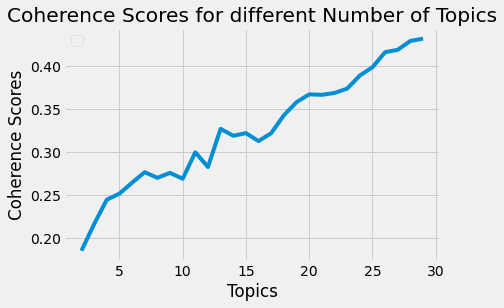

In [ ]:
#plotting the coherence score matrix from Gensim LDA Model to find the elbow for ideal number of topics
x = []
y = []
  
df = pd.read_csv('lda_tuning_results.csv')
df = df[(df['Validation_Set'] == '100% Corpus')]
x = df['Topics']
y = df['Coherence']

# plot
plt.plot(x,y)
plt.xlabel('Topics')
plt.ylabel('Coherence Scores')
plt.title('Coherence Scores for different Number of Topics')
plt.legend()
plt.show()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df_15_16 = df[(df['Year'] == 2015) | (df['Year'] == 2016)]

In [ ]:
df_15_16['clean_tweet_text']=df_15_16['clean_tweet_tokens'].apply(lambda x: ' '.join(x))

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern=r'\w{1,}')

# apply transformation
tf = vectorizer.fit_transform(df_15_16['clean_tweet_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

#to check the shape of tf
tf.shape

# the vectorizer object will be used to transform text to vector form
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=25, token_pattern=r'\w{1,}')

# apply transformation
tfidf = tfidf_vectorizer.fit_transform(df_15_16['clean_tweet_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#to check the shape of tf
tfidf.shape

(11753, 549)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(df_15_16['clean_tweet_tokens'])
# Create Corpus
texts = df_15_16['clean_tweet_tokens']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [ ]:
#Running LDA model from SciKit for the selected topics

number_of_topics = 13

# Run LDA
lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=100, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf)

In [ ]:
#Listing the words in topics with their respective weightage
topic_dict = {}
for topic_idx, topic in enumerate(lda.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
                    for i in topic.argsort()[:-8 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                    for i in topic.argsort()[:-8 - 1:-1]]
topics=pd.DataFrame(topic_dict)
topics

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights,Topic 10 words,Topic 10 weights,Topic 11 words,Topic 11 weights,Topic 12 words,Topic 12 weights
0,cruz,89.1,donald,173.5,trump,317.8,nice,97.1,poll,162.7,...,apprentice,73.0,enjoy,113.9,true,87.2,hillary,163.1,interview,89.5
1,donaldtrump,84.8,trump,153.2,thank,253.7,jeb,75.5,thank,128.1,...,golf,44.8,interviewed,82.9,real,80.9,run,149.0,book,50.2
2,man,82.7,president,148.3,makeamericagreatagain,210.7,bush,71.2,new,124.1,...,border,42.2,morning,66.8,trump,72.7,clinton,120.2,celebrity,45.5
3,rubio,61.1,gop,68.9,america,177.0,fire,61.6,amaze,98.3,...,wall,40.5,always,59.3,celebrityapprentice,71.7,crooked,77.1,isi,43.6
4,ted,56.7,one,62.4,vote,130.2,good,57.8,iowa,91.1,...,hotel,36.1,season,54.0,deal,62.1,president,63.6,potus,35.2
5,money,52.4,candidate,58.3,love,116.6,trump,39.1,night,90.9,...,politician,31.0,business,49.9,world,61.7,win,57.9,become,35.1
6,woman,51.2,hard,51.3,support,62.6,fantastic,35.9,crowd,80.1,...,plan,29.7,news,49.4,obama,53.1,trump,55.7,race,31.2
7,trump,47.8,smart,48.6,family,51.5,read,35.7,entrepreneur,80.1,...,politics,29.3,fox,46.8,start,48.9,campaign,54.3,focus,30.2


In [ ]:
topics.to_csv('topics_15_16.csv', index=False)

In [ ]:
#interative visualization to depict sparsity of words inside topics and plotting topics on coordinate system

pyLDAvis.enable_notebook()
dtm = np.matrix(tfidf)
LDAvis_prepared= pyLDAvis.sklearn.prepare(lda, dtm, vectorizer, mds='tsne')
LDAvis_prepared

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      -28.370157   75.716713       1        1  11.294334
10     140.525131  125.038422       2        1   9.349838
11     -15.713381   -6.499068       3        1   9.343124
0      -34.624741  168.429764       4        1   8.955088
2       66.229309    7.804511       5        1   8.697850
1       54.002045   90.614914       6        1   8.086923
7     -115.580109  108.730423       7        1   7.343528
5      156.040054   31.690395       8        1   7.191252
6       31.304781  -90.663383       9        1   6.724106
3      125.523102  -64.160110      10        1   6.149156
9     -110.481079   11.011040      11        1   5.997066
12      58.766029  183.607056      12        1   5.460015
8      -69.457687  -81.489365      13        1   5.407721, topic_info=                      Term        Freq       Total Category  logprob  loglift
482                  thank  385.000000  385.000000  Default  30.0000  30.0000
294  makeamericagreatagain  231.000000  231.000000  Default  29.0000  29.0000
142                  enjoy  126.000000  126.000000  Default  28.0000  28.0000
258                    job  149.000000  149.000000  Default  27.0000  27.0000
123                 donald  298.000000  298.000000  Default  26.0000  26.0000
..                     ...         ...         ...      ...      ...      ...
292                  major   23.394467   31.773123  Topic13  -3.9051   2.6112
371             politician   38.045536   82.874853  Topic13  -3.4189   2.1388
119               disaster   21.745681   30.191333  Topic13  -3.9782   2.5892
451                special   24.532039   39.456385  Topic13  -3.8577   2.4421
499                  trump   21.654642  818.683594  Topic13  -3.9824  -0.7151

[546 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1         6  0.840815        act
1         8  0.098919        act
2         9  0.954733     action
3        10  0.950996   actually
5         8  0.946714        ago
...     ...       ...        ...
545       8  0.840511       year
546       1  0.822908  yesterday
546       2  0.164582  yesterday
547       2  0.981490       york
548      13  0.957981       zero

[740 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 11, 12, 1, 3, 2, 8, 6, 7, 4, 10, 13, 9])